# A class to represent Phase Noise

## imports

In [1]:
from __future__ import division
# Matrix computation
import numpy as np
from numpy import sqrt, diff, conj
from numpy.random import randn

# Signal processing routines
import scipy.signal as sig

# Symbolic math
import sympy as sym
sym.init_printing(use_latex='mathjax')

# Plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize']  = (9,6)
matplotlib.rcParams['axes.labelsize'] = 'large'
matplotlib.rcParams['axes.grid'] = True

# Pll designer class to manipulate phase noise data
import plldesigner.pnoise as pn

## Introduction

This document present a class in the [plldesinger](https://github.com/jfosorio/plldesigner) python module used to represent phase noise.  The class have methods to compute the basic operation over phase noise, and they are:

    * Integration
    * Interpolation
    * Addition assuming statistically independence
    * Multiplication by a transfer function
    * Ploting
    * Model fit
    
The phase noise is represented by its Doubled-Sided Band(SSB) spectrum:
$$
\mathcal{L}(f_m) = 10 \log{\frac{\phi(f_m)^{2}}{2}} (dBc/Hz),
$$
where $\phi(f_m)^2$ is the Singled-Sided band (SSB) power sepectral density (rad/Hz).

## Noise addition

The addition is done assuming both signal are statistically independent. The following code shows a example of definition of noise with two vectors and the resulting power spectral density.

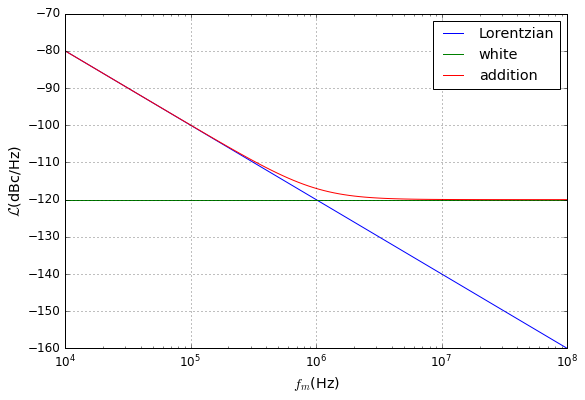

In [2]:
fm = np.logspace(4,8,100)
lorentzian  = pn.Pnoise(fm,10*np.log10(1/(fm*fm)),label='Lorentzian')
fig = lorentzian.plot()
white = pn.Pnoise(fm,-120*np.ones(fm.shape),label='white')
fig  = white.plot()
added = lorentzian+white
added.label = 'addition'
# Ploting in semilogx
added.plot()
leg = plt.legend()

In [3]:
ix, = np.where(fm>1e6)

In [4]:
added.ldbc[ix[0]]

-117.187023265

## Noise integration

In order to find the integral of the noise of phase noise when few points are available it is necesary to be carefull and not introduce and error due to the logaritmic caracteristic of the the curve. Simple numerical integration of the curve in the figure gives a large error, specially if few points are available. There are two ways to avoid this problem one is to calculate the area under the curve between two points considering the log behavior of the curve [1], the other way to deal with the asymptocally behavior of the noise is to do the integration under the assumption of a linear behavior after log-log conversion. 
The following examples introduce the two methods and compare them with the result of the symbolic integration performed with Sympy [2].

###  Using  Gardner equation

By default the phase noise class integrate the noise using the equation find in the book of Gardner [1]. This can be done by using the integrate method as:

In [5]:
x = added.integrate()
x

0.0200206409874

### Noise integration with the trapz method

Some times when used with noisy power spectrum densities, as the ones that result from transient simulations, the gardner method producing large truncation erros. In this case is better to interpolate points assuming the logaritmic tendency of the curve and then do a simple integration. This is implemented as and option in the integrate method and is ilustrated in the following

In [6]:
added.integrate(method='trapz')

0.0200206409874

### Integration using Sympy
The same calculation symbolically using Sympy that is ilustrated in the next code

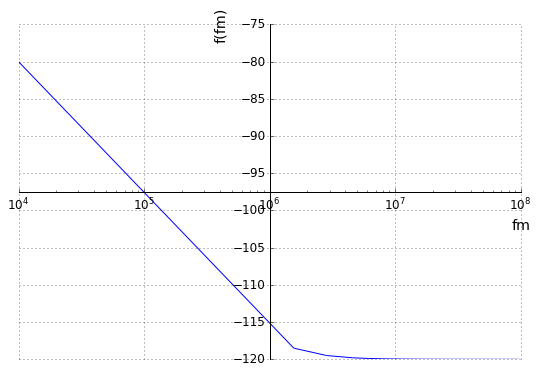

In [7]:
fm,LdBc,fl,fh = sym.symbols('fm,LdBc,fl,fh', postive=True)
phi2_white = 2*10**(-120/10)
phi2_lorentzian = 2/(fm*fm)
phi2_added = phi2_white+phi2_lorentzian
fig = plt.figure()
ax = sym.plot(10*sym.log(phi2_added/2,10),(fm,1e4,1e8), xscale = 'log')

In [8]:
x = 10*sym.log(phi2_added.subs({fm:1e6})/2,10)
x.evalf()

-116.989700043360

In [9]:
phi2_int = sym.integrate(phi2_added,fm)
phi2_int

             -2.0⋅(-1)
2.0e-12⋅fm - ─────────
                 fm   

integrating over similar limits that before 

In [10]:
sym.sqrt(phi2_int.subs({fm:1e8})-phi2_int.subs({fm:1e4}))

0.0199989999749987

This is exactly what we found numerically in previous examples

## Generating samples of the phase noise 

It is also posible to generate samples of the noise for that we generate AWNG noise in the frequency domain we weight it with the power spectrum density and we calcualte the inverse FFT to have samples back in a similar fashion tha the algorithm described in [3] This notebook shows how to generate phase noise with certain power spectral density. The signal $
\phi[n]$ is generated by first creating AWNG noise for every of the frequency points where the spectrum is sampled. The signal constructed like that is just transform to a time sequence by means of the inverse FFT.  

### Create noise with points and the slope

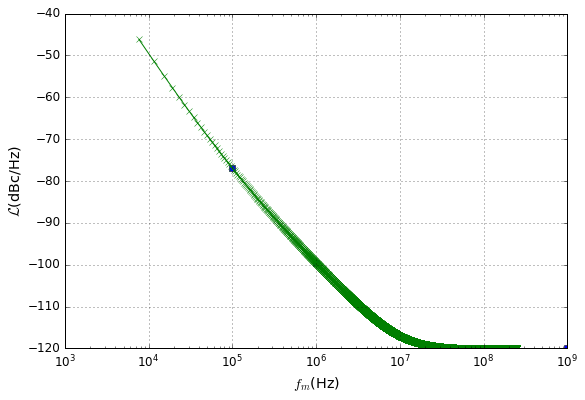

In [11]:
# Create a noise represenation with the noise points and slopes
pnobj = pn.Pnoise.with_points_slopes([1e5, 1e6, 1e9],[-80,-100,-120],[-30,-20,0])
pnobj.plot('s')
pnobj_ext = pnobj
# Interpolate the noise in the logaritmic scale
npoints = 2**16
fs = 500e6
fm  = np.linspace( fs/npoints, fs/2, npoints)
dfm = fm[1]-fm[0]
pnobj_ext.fm=fm
pnobj.plot('-', marker='x')

### Generate AWGN noise and calculate the phase in the time domain

In [12]:
# create phase noise samples
def gen_phase_noise_samples(fm, ldbc_fm, npoints):
    awgn_P1 = ( sqrt(0.5)*(randn(npoints) +1j*randn(npoints)) )
    P = 2*10**(ldbc_fm/10)
    dfm = fm[1]-fm[0]
    X = 2 * (npoints-1) * sqrt( dfm * P ) * awgn_P1
    X = np.r_[0,X, X.conj()[::-1]]
    phi = np.fft.ifft(X)
    return phi
phi = gen_phase_noise_samples(fm, pnobj.ldbc, npoints)

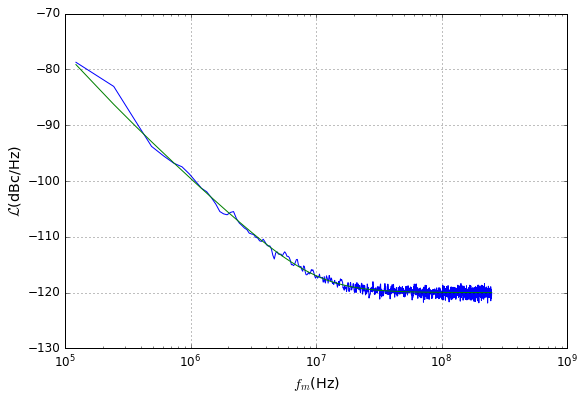

In [13]:
f, pxx = sig.welch(phi,fs, window='blackman', nperseg=2**12)
pnobj.fm = f[1:]
plt.semilogx(f[1:],10*np.log10(pxx[1:]/2))
ax = pnobj.plot('-')

notice that at low frequency offsets is it is difficult to have the noise right, the reason being that the number of samples is small.

### Create noise samples using the pnoise class
This algoritm it is implemented as a method in the pnoise class and can be used, conveniently, as described in the following code.

In [14]:
## create a phase noise model with the points and slops
pnobj = pn.Pnoise.with_points_slopes([1e5, 1e6, 1e9],[-80,-100,-120],[-30,-20,0])
fs = 500e6
npoints = 2**16
phi = pnobj.generate_samples(npoints, fs)

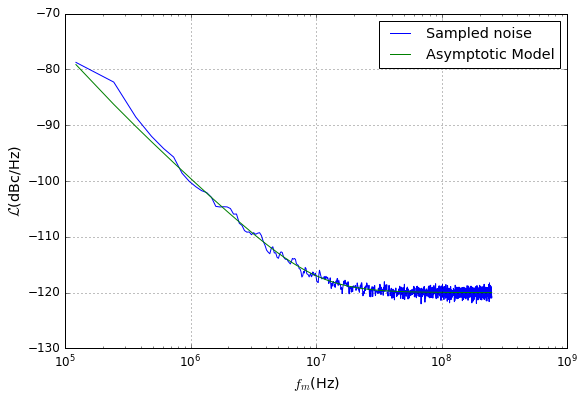

In [15]:
##Calculate the power spectral density
f, pxx = sig.welch(phi,fs, window='blackman', nperseg=2**12)
pnobj.fm = f[1:]
plt.semilogx(f[1:],10*np.log10(pxx[1:]/2), label = 'Sampled noise')
pnobj.plot('-', label='Asymptotic Model')
leg = plt.legend()

## Conclusion
This notebook shows how to use the pnoise class in the plldesiner model to automate some operation over phase noise frequency domain representations. There are other methods that are not documented here and can be found in [plldesigner](https://github.com/jfosorio/plldesigner).

## References

[1] F. M. Gardner, Phaselock Techniques, 3 edition. Hoboken, NJ: Wiley-Interscience, 2005.

[2] SymPy Development Team, SymPy: Python library for symbolic mathematics. 2014.

[3] http://nl.mathworks.com/matlabcentral/fileexchange/8844-phase-noise/content/dd_phase_noise.m